In [1]:
### The lab was done already by Ultimate-Gryffindor-Teamwork-Supreme
### Though, this lab is yet to be finished. I want to clean up a lot more and trying out a few things
### myself. Just to see if the models improves or not.

In [2]:
# prep: import modules and get pwd
import seaborn as sns
import matplotlib.pyplot as plt
import pymysql
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [4]:
# 1.
# Create a query or queries to extract the information you think may be relevant for building the prediction model. 
# It should include some film features and some rental features. Use the data from 2005.

In [5]:
# 
query = '''
select

c.name as 'genre',
f.rental_duration,
f.rental_rate,
f.length,
f.rating,
f.special_features,
p.amount,
case 
when rental_date like "2005-05-%%" then True
else False 
end as 'rented' -- target

from language l
join film f using (language_id)
join film_category fc using (film_id)
join category c using (category_id)
join inventory i using (film_id)
join rental r using (inventory_id)
join payment p using (customer_id)

group by film_id;
'''
features = pd.read_sql_query(query, engine)

In [6]:
display(features.shape)
display(features.head())
display(features.nunique())

(958, 8)

,genre,rental_duration,rental_rate,length,rating,special_features,amount,rented
0,Documentary,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",2.99,0
1,Horror,3,4.99,48,G,"Trailers,Deleted Scenes",8.99,0
2,Documentary,7,2.99,50,NC-17,"Trailers,Deleted Scenes",7.99,0
3,Horror,5,2.99,117,G,"Commentaries,Behind the Scenes",2.99,0
4,Family,6,2.99,130,G,Deleted Scenes,3.99,1


genre                16
rental_duration       5
rental_rate           3
length              140
rating                5
special_features     15
amount               11
rented                2
dtype: int64

In [7]:
display(features['genre'].unique()) # usable
display(features['rental_duration'].unique()) # usable
display(features['rental_rate'].unique()) # useable 
display(features['length'].unique()) # usable
display(features['rating'].unique()) # usable
display(features['amount'].value_counts()) # usable
display(features['special_features'].unique()) # splitting

array(['Documentary', 'Horror', 'Family', 'Foreign', 'Comedy', 'Sports',
       'Music', 'Animation', 'Action', 'New', 'Sci-Fi', 'Classics',
       'Games', 'Children', 'Travel', 'Drama'], dtype=object)

array([6, 3, 7, 5, 4], dtype=int64)

array([0.99, 4.99, 2.99])

array([ 86,  48,  50, 117, 130, 169,  62,  54, 114,  63, 126, 136, 150,
        46, 180,  82,  57, 113,  79, 129,  85,  92, 181,  74, 179,  91,
       168, 119, 147, 121,  99, 148, 170,  83, 108, 153, 118, 162, 182,
        75, 173,  87,  65,  90, 122, 160,  89, 175, 106,  73, 151, 100,
        53,  77, 142,  93, 163, 103,  61,  71, 102,  98,  72, 176, 123,
        56, 161,  60, 133, 125,  52, 120, 167,  70, 135, 112, 110, 152,
        51, 146,  66, 185, 124, 107, 101, 143, 165,  81, 164,  58,  95,
       139,  55, 149, 109,  67,  76, 172, 115, 184, 166,  64, 104,  69,
        84, 144,  59,  88, 141,  94,  68,  47,  49, 177, 154, 159, 178,
        96, 116, 132, 171, 140, 155, 158, 174, 138,  97, 131, 156,  80,
       111, 183, 128, 137, 127, 157,  78, 105, 134, 145], dtype=int64)

array(['PG', 'G', 'NC-17', 'PG-13', 'R'], dtype=object)

4.99     220
0.99     200
2.99     189
5.99      77
6.99      76
3.99      74
7.99      36
1.99      29
9.99      26
8.99      25
11.99      6
Name: amount, dtype: int64

array(['Deleted Scenes,Behind the Scenes', 'Trailers,Deleted Scenes',
       'Commentaries,Behind the Scenes', 'Deleted Scenes', 'Trailers',
       'Commentaries,Deleted Scenes',
       'Trailers,Commentaries,Behind the Scenes', 'Trailers,Commentaries',
       'Trailers,Behind the Scenes',
       'Commentaries,Deleted Scenes,Behind the Scenes',
       'Trailers,Commentaries,Deleted Scenes',
       'Trailers,Deleted Scenes,Behind the Scenes', 'Behind the Scenes',
       'Trailers,Commentaries,Deleted Scenes,Behind the Scenes',
       'Commentaries'], dtype=object)

In [8]:
# dealing with special_features
# putting every special feature in a extra list, then adding it to features dataframe
###### trailers
trailers=[]
for i in features["special_features"]:
    if "Trailers" in i == "Trailers":
        trailers.append(1)
    else:
        trailers.append(0)
features["trailers"] = trailers  

###### behind the scenes
bscenes=[]
for i in features["special_features"]:
    if "Behind the Scenes" in i == "Behind the Scenes":
        bscenes.append(1)
    else:
        bscenes.append(0)
        
features["behind_the_scenes"] = bscenes  

###### commentaries     
comment=[]
for i in features["special_features"]:
    if "Commentaries" in i == "Commentaries":
        comment.append(1)
    else:
        comment.append(0)

features["commentaries"] = comment 

###### deleted scenes
dscenes=[]
for i in features["special_features"]:
    if "Deleted Scenes" in i == "Deleted Scenes":
        dscenes.append(1)
    else:
        dscenes.append(0)
        
features["deleted_scenes"] = dscenes 

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre              958 non-null    object 
 1   rental_duration    958 non-null    int64  
 2   rental_rate        958 non-null    float64
 3   length             958 non-null    int64  
 4   rating             958 non-null    object 
 5   special_features   958 non-null    object 
 6   amount             958 non-null    float64
 7   rented             958 non-null    int64  
 8   trailers           958 non-null    int64  
 9   behind_the_scenes  958 non-null    int64  
 10  commentaries       958 non-null    int64  
 11  deleted_scenes     958 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 89.9+ KB


In [10]:
# 2.
# Create a query to get the list of films and a boolean indicating if it was rented last month (May 2005). 
# This would be our target variable.

In [11]:
# target is already in features
# query = '''
# select
# film_id,
# count(*) as film_rented,
# case 
# when rental_date like "2005-05-%%" then True
# else False 
# end as 'rented' -- target

# from rental
# join inventory using (inventory_id)
# join film using (film_id)
# group by film_id
# ;
# '''
# # count(*) as film_rented,


In [12]:
# 3.
# Read the data into a Pandas dataframe.

In [13]:
# target dataframe
# x - y - split
y = features.rented
y.value_counts()

0    733
1    225
Name: rented, dtype: int64

<AxesSubplot:>

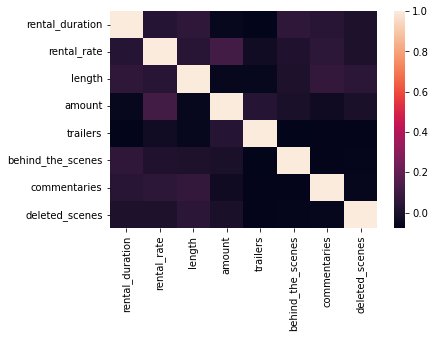

In [14]:
# 4.
# Analyze extracted features and transform them. 
# You may need to encode some categorical variables, or scale numerical variables.
X = features.drop(['rented','special_features'],axis=1)
sns.heatmap(X.corr())

In [15]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

In [16]:
## transforming nums

In [17]:
num_train = X_train.select_dtypes(np.number)
num_test = X_test.select_dtypes(np.number)
num_train.head()

,rental_duration,rental_rate,length,amount,trailers,behind_the_scenes,commentaries,deleted_scenes
741,4,4.99,110,4.99,1,0,0,0
681,6,2.99,73,4.99,1,0,0,0
628,3,0.99,128,2.99,0,0,0,0
225,4,0.99,68,9.99,0,0,0,0
861,7,0.99,144,4.99,0,0,0,0


In [18]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler().fit(num_train)
num_train_minmax = transformer.transform(num_train)
num_test_minmax = transformer.transform(num_test)
pd.DataFrame(num_train_minmax).head()

,0,1,2,3,4,5,6,7
0,0.25,1.0,0.460432,0.363636,1.0,0.0,0.0,0.0
1,0.75,0.5,0.194245,0.363636,1.0,0.0,0.0,0.0
2,0.00,0.0,0.589928,0.181818,0.0,0.0,0.0,0.0
3,0.25,0.0,0.158273,0.818182,0.0,0.0,0.0,0.0
4,1.00,0.0,0.705036,0.363636,0.0,0.0,0.0,0.0


In [19]:
## transforming cats

In [20]:
cat_train= X_train.select_dtypes(object)
cat_test= X_test.select_dtypes(object)
cat_train.head()

,genre,rating
741,Drama,PG-13
681,Sci-Fi,NC-17
628,Travel,PG
225,Comedy,R
861,Classics,NC-17


In [21]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='error', drop='first').fit(cat_train) 
# handle_unknown='error' fuer unvorhergesehene kategorien
cat_train_ohe = ohe.transform(cat_train).toarray()
cat_test_ohe = ohe.transform(cat_test).toarray()
pd.DataFrame(cat_train_ohe).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
## concatinating them together
X_train = np.concatenate((num_train_minmax,cat_train_ohe),axis=1)
X_test = np.concatenate((num_test_minmax,cat_test_ohe),axis=1)

In [25]:
# 5.
# Create a logistic regression model to predict this variable from the cleaned data.

In [26]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='saga').fit(X_train, y_train)

In [27]:
# 6.
# Evaluate the results.

In [28]:
predictions = classification.predict(X_test)
display(predictions)
print('score: ',classification.score(X_test, y_test))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

score:  0.7986111111111112


In [29]:
# confusion matrix 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)
# 0 - not rented, 1 - rented
# because of the imbalance of the target the predictions are in favor of the majority (not rented)

array([[230,   1],
       [ 57,   0]], dtype=int64)